<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/GTZAN_Dataset_Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [GTZAN Dataset - Music Genre Classification](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/archive.zip', './data')

## Reffering to [Kaggle, Music Genre Classification using CNN](https://www.kaggle.com/code/soumyasharma20/music-genre-classification-using-cnn)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

# make sure ffmpeg is installed as backend.
!apt install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# Dataset location
SOURCE_PATH = '/content/data/Data/genres_original'

# Path to labels and processed data file, json format.
JSON_PATH = './data.json'

# Sampling rate.
sr = 22050

# Let's make sure all files have the same amount of samples and pick a duration right under 30 seconds.
TOTAL_SAMPLES = 29 * sr

# The dataset contains 999 files. Lets make it bigger.
# X amount of slices => X times more training examples.
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [ ]:
def preprocess_data(source_path, json_path):

    # Let's create a dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Let's browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != '/content/data/Data/genres_original/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE
                    mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                    mfcc = mfcc.T
                    mydict["labels"].append(i-1)
                    mydict["mfcc"].append(mfcc.tolist())
            else:
                pass

    # Let's write the dictionary in a json file.
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [ ]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Let's load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [ ]:
def prepare_datasets(inputs, targets, split_size):

    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size, stratify=targets)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size, stratify=targets_train)

    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]

    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [ ]:
def design_cnn_model(input_shape):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

### Reffering to RNN model : [Kaggle, intro to audio with Deep Learning](https://www.kaggle.com/code/riadalmadani/intro-to-audio-with-deep-learning)

In [ ]:
def design_rnn_model(input_shape):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([

        # 64 represnets the number of units NOT cells
        # the number of cells equal to the numper of steps which is 130 here

        tf.keras.layers.LSTM(64,input_shape=input_shape, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [ ]:
def make_prediction(model, X, y, idx):

    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }

    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])

    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [ ]:
def plot_performance(hist):

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 123, 11, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 6, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 4, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 2, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 29, 1, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,514 (177.79 KB)

 Trainable params: 45,322 (177.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.3567 - loss: 1.9022 - val_accuracy: 0.4384 - val_loss: 1.5394
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.5617 - loss: 1.2156 - val_accuracy: 0.5586 - val_loss: 1.2403
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.6361 - loss: 1.0231 - val_accuracy: 0.6096 - val_loss: 1.1027
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.6737 - loss: 0.8810 - val_accuracy: 0.6471 - val_loss: 0.9607
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7169 - loss: 0.7971 - val_accuracy: 0.7057 - val_loss: 0.8465
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.7419 - loss: 0.7383 - val_accuracy: 0.6572 - val_loss: 0.9975
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.7686 - loss: 0.6598 - val_accuracy: 0.7302 - val_loss: 0.8022
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.7787 - loss: 0.6

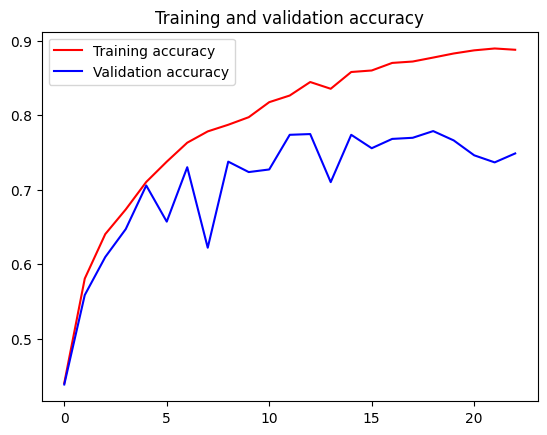

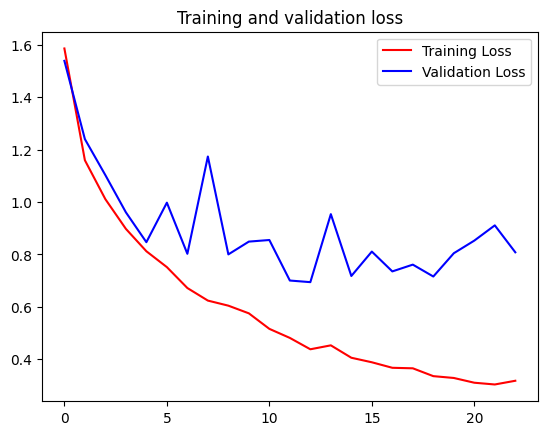

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

---Now testing the model for one audio file---
The model predicts: metal, and ground truth is: metal.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7279 - loss: 0.8327
Accuracy on test is 0.7460913062095642
Test error is 0.8080369830131531



NameError: name 'design_dnn_model' is not defined

In [ ]:
if __name__ == "__main__":
    preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)

    inputs, targets = load_data(json_path=JSON_PATH)

    Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

    input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
    model = design_cnn_model(input_shape)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    model.compile(optimizer = tf.keras.optimizers.AdamW(),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['accuracy']
                     )

    model.summary()

    #Training the model.
    history = model.fit(Xtrain, ytrain,
                        validation_data=(Xval, yval),
                        epochs=50,
                        batch_size=32,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                        )

    plot_performance(history)

    # Testing the model on never seen before data.
    make_prediction(model, Xtest, ytest, 24)

    test_error , test_accuracy = model.evaluate(Xtest,ytest,verbose=1)
    print("Accuracy on test is {}".format(test_accuracy))
    print("Test error is {}".format(test_error))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 125, 64)             │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,802 (225.79 KB)

 Trainable params: 57,802 (225.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 204ms/step - accuracy: 0.2785 - loss: 1.9793 - val_accuracy: 0.4895 - val_loss: 1.4704
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 263ms/step - accuracy: 0.4517 - loss: 1.5520 - val_accuracy: 0.5155 - val_loss: 1.3794
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - accuracy: 0.5004 - loss: 1.3748 - val_accuracy: 0.5310 - val_loss: 1.3075
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.5426 - loss: 1.2743 - val_accuracy: 0.5696 - val_loss: 1.1974
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 208ms/step - accuracy: 0.5836 - loss: 1.1840 - val_accuracy: 0.5896 - val_loss: 1.1590
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 227ms/step - accuracy: 0.6002 - loss: 1.1238 - val_accuracy: 0.6166 - val_loss: 1.0983
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 189ms/step - accuracy: 0.6270 - loss: 1.0589 - val_accuracy: 0.5981 - val_loss: 1.0910
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.6472 - loss: 0

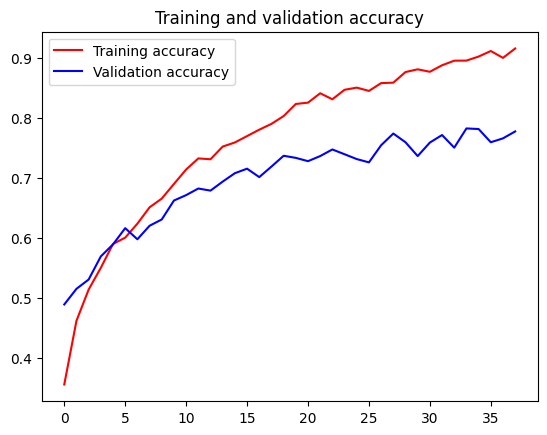

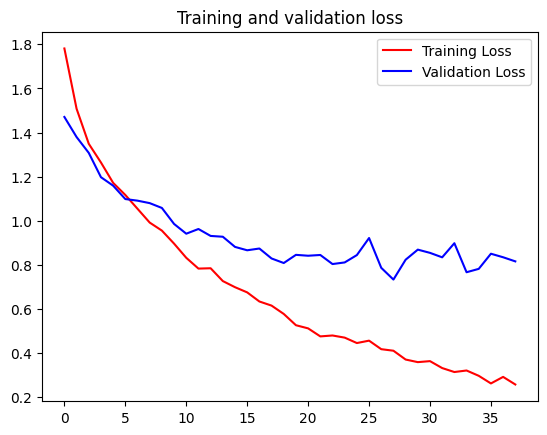

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step

---Now testing the model for one audio file---
The model predicts: metal, and ground truth is: metal.

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.7794 - loss: 0.8278
Accuracy on test is 0.7717323303222656
Test error is 0.8460813760757446


In [ ]:
if __name__ == "__main__":
    preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)

    inputs, targets = load_data(json_path=JSON_PATH)

    Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

    input_shape = (Xtrain.shape[1], Xtrain.shape[2])

    model = design_rnn_model(input_shape)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    model.compile(optimizer = tf.keras.optimizers.AdamW(),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['accuracy']
                  )

    model.summary()

    #Training the model.
    history = model.fit(Xtrain, ytrain,
                        validation_data=(Xval, yval),
                        epochs=50,
                        batch_size=32,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                      )

    plot_performance(history)

    # Testing the model on never seen before data.
    make_prediction(model, Xtest, ytest, 24)

    test_error, test_accuracy = model.evaluate(Xtest,ytest,verbose=1)
    print("Accuracy on test is {}".format(test_accuracy))
    print("Test error is {}".format(test_error))